In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter("ignore")

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


In [ ]:
# Загрузим данные

new_data = pd.read_excel('Formula_1_dataset.xlsx')

new_data.head()

In [ ]:
# Обработаем данные

new_missing_values = new_data.isnull().sum()

new_unique_values = new_data.nunique()

new_missing_and_unique_values = pd.DataFrame({'Missing Values': new_missing_values, 'Unique Values': new_unique_values})
new_missing_and_unique_values.sort_values(by='Missing Values', ascending=False)


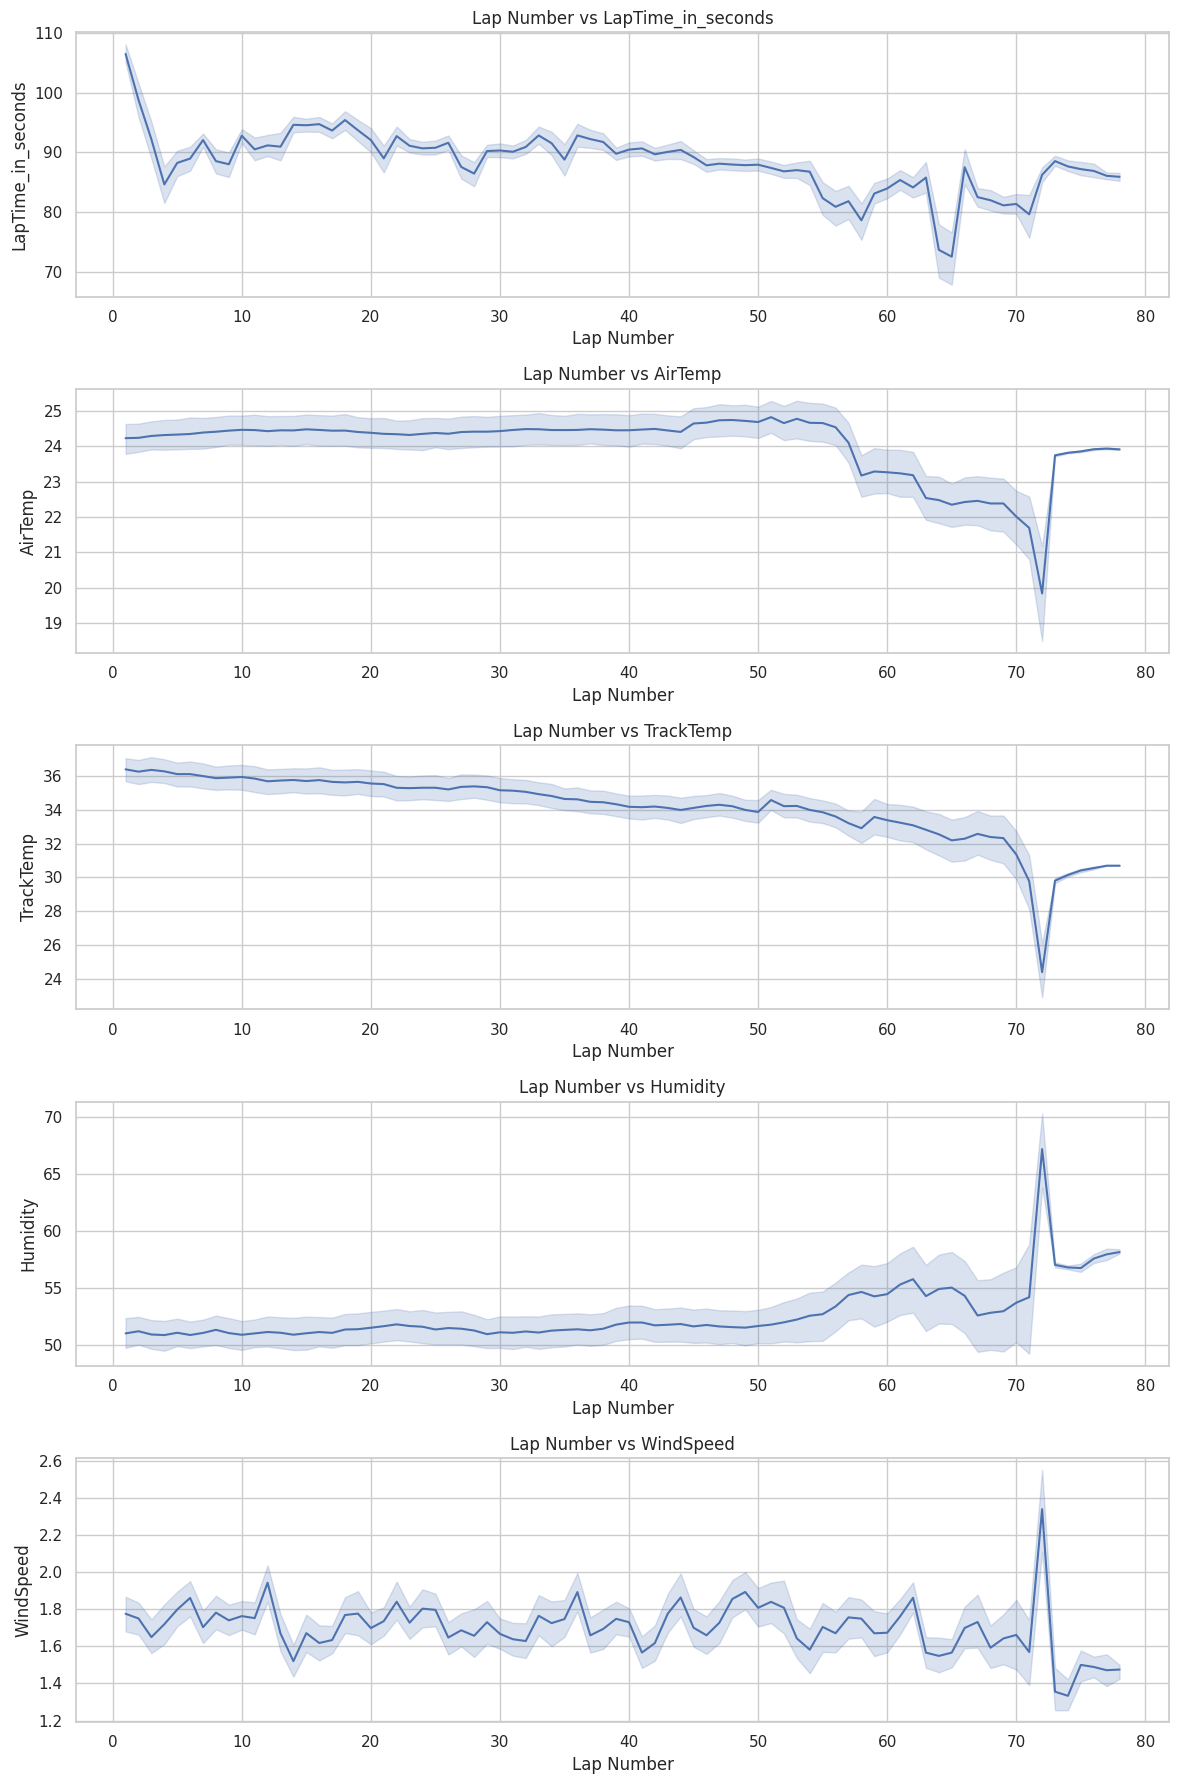

In [4]:
sns.set(style="whitegrid")

columns_to_plot = [ 'LapTime_in_seconds', 'AirTemp', 'TrackTemp', 'Humidity', 'WindSpeed']

fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(12, 18))

for i, col in enumerate(columns_to_plot):
    sns.lineplot(data=new_data, x='LapNumber', y=col, ax=axes[i])
    axes[i].set_title(f'Lap Number vs {col}')
    axes[i].set_xlabel('Lap Number')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

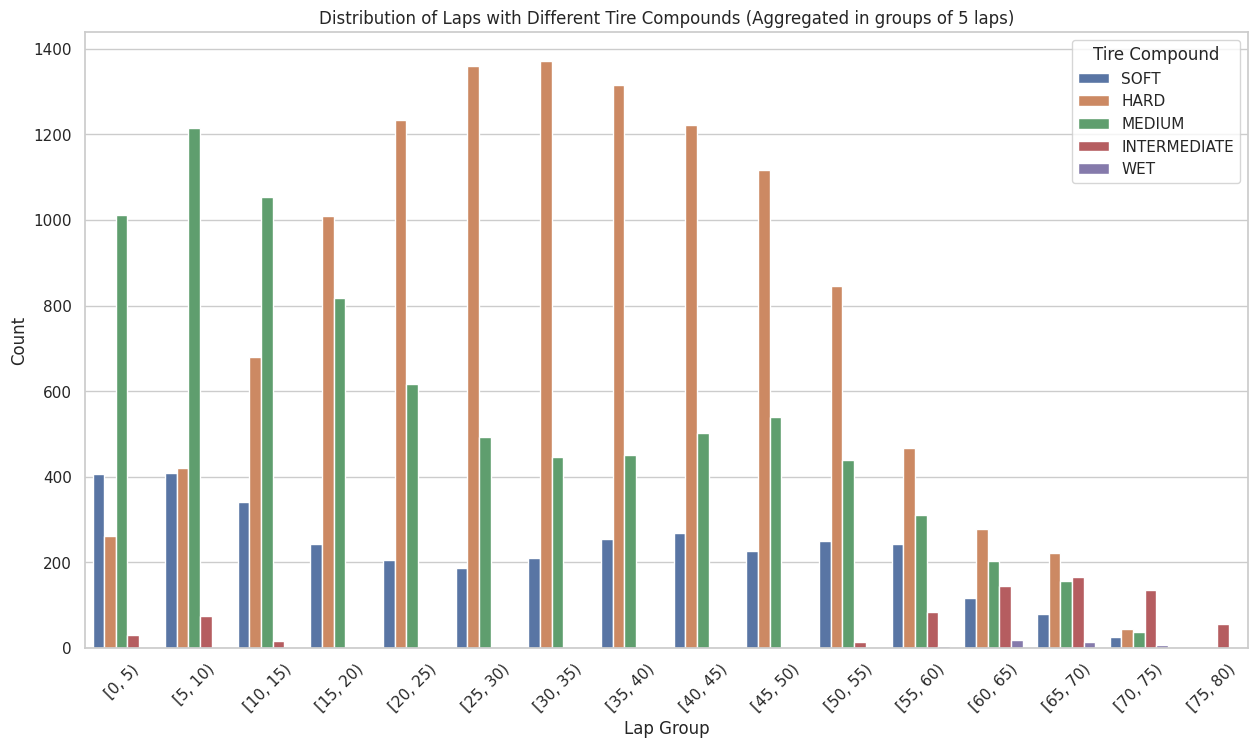

In [29]:
# Объединим круги в группы по 5 штук и построим график распределения состава шин для этих объединенных кругов.
unique_compounds = new_data['Compound'].unique()

# Создадим новый столбца для агрегированных групп кругов (например, круги 1-5, 6-10 и т.д.)
new_data['LapGroup'] = pd.cut(new_data['LapNumber'], bins=range(0, max(new_data['LapNumber']) + 5, 5), right=False)

# Построим график распределения кругов с использованием каждого состава шин для каждой из полученных групп.
plt.figure(figsize=(15, 8))
sns.countplot(x='LapGroup', hue='Compound', data=new_data)
plt.title('Distribution of Laps with Different Tire Compounds (Aggregated in groups of 5 laps)')
plt.xlabel('Lap Group')
plt.ylabel('Count')
plt.legend(title='Tire Compound', labels=unique_compounds)
plt.xticks(rotation=45)

plt.show()

In [30]:
# Создадим новый датафрейм для преобразованных данных
categorical_cols = new_data.select_dtypes(include=['object', 'bool']).columns
numerical_cols = new_data.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(['PitFlag','Position'])
transformed_df = new_data.copy()

# Преобразуем все категориальные столбцы в строковый тип
for col in categorical_cols:
    new_data[col] = new_data[col].astype(str)



label_encoder = LabelEncoder()
for col in categorical_cols:
    transformed_df[col] = label_encoder.fit_transform(new_data[col])
transformed_df.head()


label_encoder = LabelEncoder()
for col in categorical_cols:
    transformed_df[col] = label_encoder.fit_transform(new_data[col])
for col in numerical_cols:
    transformed_df[col] = StandardScaler().fit_transform(new_data[[col]])

transformed_df = transformed_df.drop(['LapGroup'],axis=1)
transformed_df.head()


,Time,Driver,Position,DriverNumber,PitFlag,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,...,IsAccurate,LapTime_in_seconds,laptime_sum_sectortimes,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,48,20,1,-1.159067,0,12731,-1.606925,-1.184051,-3.226265,0.842232,...,0,0.516900,-4.369246,0.674409,-2.017359,0.58553,0,-0.503372,0.563311,-1.245745
1,97,20,1,-1.159067,0,12116,-1.552696,-1.184051,0.348890,0.853676,...,1,0.457977,0.397534,0.674409,-2.017359,0.58553,0,-0.517005,0.364427,-1.753953
2,148,20,1,-1.159067,0,12137,-1.498466,-1.184051,0.354137,0.849226,...,1,0.459781,0.399091,0.674409,-2.017359,0.58553,0,-0.503372,-0.055438,-1.144104
3,165,20,1,-1.159067,0,12117,-1.444236,-1.184051,0.340791,0.871224,...,1,0.458090,0.397632,0.674409,-2.017359,0.58553,0,-0.503372,0.320231,-1.347387
4,229,20,1,-1.159067,0,12157,-1.390006,-1.184051,0.337712,0.881650,...,1,0.461416,0.400502,0.651836,-2.017359,0.58553,0,-0.530638,0.342329,-0.737538


In [31]:
data = transformed_df

# Разобьём данные на фичи и таргет
X = data.drop(['Position'], axis=1)  # Фичи
y_position = data['Position']  # Таргет

# Разобьём данные на обучающие и тестовые выборки
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_position, test_size=0.2, random_state=42)


# Повторим для 'PitFlag'
X1 = data.drop(['Position', 'PitFlag'], axis=1)  # Фичи
y_pitflag = data['PitFlag']  # Таргет 'PitFlag'

# Разобьём данные на обучающие и тестовые выборки для 'PitFlag'
X_train_pf, X_test_pf, y_train_pf, y_test_pf = train_test_split(X1, y_pitflag, test_size=0.2, random_state=42)


In [32]:
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

meta_learner = LogisticRegression()

stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

stacked_model.fit(X_train_pf, y_train_pf)

y_pred = stacked_model.predict(X_test_pf)

print("Accuracy:", accuracy_score(y_test_pf, y_pred))
print("\nClassification Report:\n", classification_report(y_test_pf, y_pred))

Accuracy: 0.9979495591552183

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4504
           1       0.99      0.98      0.99       373

    accuracy                           1.00      4877
   macro avg       1.00      0.99      0.99      4877
weighted avg       1.00      1.00      1.00      4877



In [15]:
# Спрогнозируем круги для остановки

sample_data = X1.iloc[0:57]
actual_label = y_pitflag.iloc[0:56]

pred = stacked_model.predict(sample_data)

Pit_lap = np.where(pred == 1)[0]
print(f"Гонщик должен совершить пит-стоп на {Pit_lap} кругах")


Гонщик должен совершить пит-стоп на [13 14 35 36] кругах


In [27]:
data = transformed_df

# Разобьём данные на фичи и таргет
X = data.drop(['Position'], axis=1)  # Features
y_position = data['Position']  # Target for 'Position'

# Разобьём данные на обучающие и тестовые выборки
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_position, test_size=0.2, random_state=42)

X1 = data.drop(['Position', 'PitFlag'], axis=1)  # Фичи

# Повторим для 'PitFlag'
y_pitflag = data['PitFlag']  # Таргет для 'PitFlag'

# Разобьём данные на обучающие и тестовые выборки для 'PitFlag'
X_train_pf, X_test_pf, y_train_pf, y_test_pf = train_test_split(X1, y_pitflag, test_size=0.2, random_state=42)


In [ ]:
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

meta_learner = LogisticRegression()

stacked_model1 = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

stacked_model1.fit(X_train_pos, y_train_pos)

y_pred = stacked_model1.predict(X_test_pos)
print("Accuracy:", accuracy_score(y_test_pos, y_pred))
print("\nClassification Report:\n", classification_report(y_test_pos, y_pred))


In [28]:
# Спрогнозируем позицию гонщика

sample_data = X.iloc[0:57]
actual_label = y_position[56]

pred = stacked_model1.predict(sample_data)

print(f"Прогнозируемая позиция гонщика: {pred[-1]}")
print(f"Актуальная позиция гонщика: {actual_label}")


Прогнозируемая позиция гонщика: 1
Актуальная позиция гонщика: 1
